In [1]:
config_path = r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\config.yaml"
import cv2
import numpy as np
import os
import glob
import pandas as pd
import csv
import yaml
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
def get_config(config_path:str) :
    with open(config_path, 'r') as ymlfile:
        cfg = yaml.load(ymlfile)
    return cfg

_config = get_config(config_path)

os.chdir(_config["fruits-image-path"])
fileNames = glob.glob("*/*.jpg")
targetLabels=[]
for fileName in fileNames:
    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])
distinct_target_labels = pd.Series(targetLabels).unique()
le = LabelEncoder()
le.fit(targetLabels)
target = le.transform(targetLabels)
X_train, X_test, y_train, y_test = train_test_split(fileNames, target, random_state=42)

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
#sift = cv2.ORB_create()
sift = cv2.xfeatures2d.SIFT_create()
dico = []
for fileName in X_train:
    img = cv2.imread(os.path.join(_config["fruits-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    for d in des:
        dico.append(d)

In [4]:
k = 700
batch_size = np.size(os.listdir(_config["fruits-image-path"])) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method: k-means++
Inertia for init 1/3: 5547419.194444
Init 2/3 with method: k-means++
Inertia for init 2/3: 5871786.238095
Init 3/3 with method: k-means++
Inertia for init 3/3: 6609308.604167
Minibatch iteration 1/1923500: mean batch inertia: 97590.456223, ewa inertia: 97590.456223 
Minibatch iteration 2/1923500: mean batch inertia: 95456.598923, ewa inertia: 97590.234346 
Minibatch iteration 3/1923500: mean batch inertia: 95391.825750, ewa inertia: 97590.005758 
Minibatch iteration 4/1923500: mean batch inertia: 93311.623836, ewa inertia: 97589.560895 
Minibatch iteration 5/1923500: mean batch inertia: 88512.805096, ewa inertia: 97588.617103 
Minibatch iteration 6/1923500: mean batch inertia: 87771.639121, ewa inertia: 97587.596342 
Minibatch iteration 7/1923500: mean batch inertia: 85093.721025, ewa inertia: 97586.297241 
Minibatch iteration 8/1923500: mean batch inertia: 89955.101399, ewa inertia: 97585.503756 
Minibatch iteration 9/1923500: mean batch inertia: 84846.

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=306 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=306 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=306 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


In [5]:
kmeans.verbose = False
histo_list = []
for fileName in X_train:
    img = cv2.imread(os.path.join(_config["fruits-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefer to add 1/nkp directly
    histo_list.append(histo)    

In [6]:
X = np.array(histo_list)

#mlp = MLPClassifier(verbose=True, max_iter=600)
#mlp.fit(X, y_train)
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
predictions = []
xes_test = []
for fileName in X_test:
    img = cv2.imread(os.path.join(_config["fruits-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    x = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp
    #res = clf.predict_proba([x])
    predictions.append(clf.predict([x]))
    xes_test.append(x)
    

In [9]:
XX = X.copy()
XX = np.concatenate((XX, np.array(xes_test)))
YY = np.concatenate((y_train, y_test))

In [10]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
rfclf_param_grid = {
  "n_estimators": [100, 300, 500],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(XX, YY)

report(rfclf_grid_search.cv_results_) 

df_gr = pd.DataFrame(rfclf_grid_search.cv_results_)
df_gr = df_gr[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_max_depth', 'param_max_features', 'param_n_estimators']]
df_gr.index.name = 'id'
df_gr = df_gr.round(4)
df_gr.to_csv('grid_rfr_fruits_sift.csv', sep=';', float_format='%.4f')

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.443 (std: 0.032)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.407 (std: 0.035)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.398 (std: 0.036)
Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 500}



In [11]:
mlpclf_param_grid = {"hidden_layer_sizes": [(100,), (150,)], #(100,30), (50,50), (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.00003, 0.0001, 0.001], #0.0001, 0.005, 
              "max_iter": [200, 500]} # 100, 200 worse, does not converge
mlpclf = MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(XX, YY)

report(mlpclf_grid_search.cv_results_) 

df_grm = pd.DataFrame(mlpclf_grid_search.cv_results_)
df_grm = df_grm[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_hidden_layer_sizes', 'param_alpha', 'param_max_iter']]
df_grm.index.name = 'id'
df_grm = df_grm.round(4)
df_grm.to_csv('grid_mlp_fruits_sift.csv', sep=';', float_format='%.4f')

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.526 (std: 0.051)
Parameters: {'activation': 'relu', 'alpha': 3e-05, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.523 (std: 0.057)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.520 (std: 0.061)
Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}



In [12]:
classifiers = [("Kneighbors", KNeighborsClassifier()),
               ('GaussianNB', GaussianNB()), 
               ('RandomForest', RandomForestClassifier()),
               ('RandomForest_OPT', RandomForestClassifier(n_estimators=500)),
               ('SVC', SVC()),
               ('MLP', MLPClassifier()),
               ('MLP_OPT', MLPClassifier(alpha=0.00003, hidden_layer_sizes=(150,), max_iter=500))
              ]
arr = []
times=[]
for classifier_tuple in classifiers:
    print(classifier_tuple[0]) 
    start = datetime.datetime.now()
    scores = cross_val_score(classifier_tuple[1], XX, YY, cv=10)
    #print(cross_val_score(classifier, train, target, cv=3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    arr.append(scores.mean())
    times.append((datetime.datetime.now() - start).seconds)
    
    Xp_train, Xp_test, yp_train, yp_test =  train_test_split(XX, YY, random_state=42)
    classifier_tuple[1].fit(Xp_train, yp_train)
    yp_pred = classifier_tuple[1].predict(Xp_test)
    fig, ax = plt.subplots(1, 1, figsize=(14, 14), dpi=200)
    plt.rcParams.update({'font.size': 15})
    cm = confusion_matrix(yp_test, yp_pred)
    df_cm = pd.DataFrame(cm, index=distinct_target_labels, columns=distinct_target_labels)
    g = sns.heatmap(df_cm, annot=True,ax=ax)
    a = plt.title('Confusion Matrix of ' + classifier_tuple[0] + ' (Accuracy: ' + "{:.2f}".format(scores.mean()) + ')')
    g.get_figure().savefig(os.path.join(_config["plot-path"],'plots','cm_fruits_sift_' + classifier_tuple[0] + "_{:.0f}".format(scores.mean()*100)+'.png'))
    plt.close()

Kneighbors
Accuracy: 0.31 (+/- 0.05)
GaussianNB
Accuracy: 0.39 (+/- 0.09)
RandomForest
Accuracy: 0.24 (+/- 0.06)
RandomForest_OPT
Accuracy: 0.42 (+/- 0.07)
SVC
Accuracy: 0.08 (+/- 0.02)
MLP
Accuracy: 0.39 (+/- 0.05)
MLP_OPT
Accuracy: 0.52 (+/- 0.11)


c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [13]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr,columns=['accuracy'])
df['classifier'] = classifier_names
df['runtime'] = times

Text(0.5, 1.0, 'Performance by classifier')

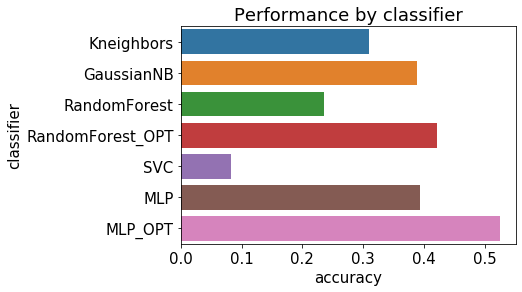

In [14]:
sns.barplot(x="accuracy", y="classifier", data=df)
plt.title('Performance by classifier')

Text(0.5, 1.0, 'Runtime by classifier')

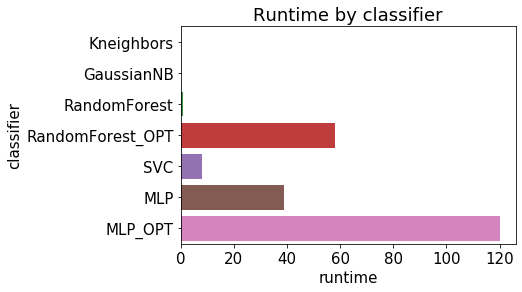

In [15]:
sns.barplot(x="runtime", y="classifier", data=df)
plt.title('Runtime by classifier')